In [2]:
using Pkg
Pkg.add("Latexify");
Pkg.add("LaTeXStrings");
Pkg.add("LinearAlgebra");
Pkg.add("JuMP");
Pkg.add("Clp");
Pkg.add("PyPlot");
Pkg.add("NamedArrays")
Pkg.add("CSV");
Pkg.add("DataFrames");

ENV["GUROBI_HOME"] = "/Library/gurobi911/mac64"
ENV["GRB_LICENSE_FILE"] = "/Library/gurobi911/gurobi.lic"
Pkg.add("Gurobi")
Pkg.build("Gurobi")

Pkg.status();

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

Status `~/.julia/environments/v1.5/Project.toml`
  [336ed68f] CSV v0.8.3
  [e2554f3b] Clp v0.8.3
  [a93c6f00] DataFrames v0.22.5
  [e2685f51] ECOS v0.12.2
  [60bf3e95] GLPK v0.14.5
  [2e9cd046] Gurobi v0.9.9
  [7073ff75] IJulia v1.23.1
  [c601a237] Interact v0.10.3
  [b6b21f68] Ipopt v0.6.5
  [4076af6c] JuMP v0.21.5
  [b964fa9f] LaTeXStrings v1.2.0
  [23fbe1c1] Latexify v0.14.7
  [86f7a689] NamedArrays v0.9.4
  [91a5bcdd] Plots v1.10.2
  [d330b81b] PyPlot v2.9.0
  [c946c3f1] SCS v0.7.1
  [37e2e46d] LinearAlgebra


In [42]:
println("Homework 4 - Jacob Lorenz")

Homework 4 - Jacob Lorenz


# Problem 1 - Max-Flow / Min-Cost

**Ollivander, the famous wand maker of Diagon Alley, has a logistics problem. He produces wands of seven different types for which he must arrange the delivery to a favored customer using five owls. There's a limit to the total number of wands that each owl can carry as shown in the code below. Each owl can carry at most one type of wand of each type. Ollivander wants to deliver as many total wands to customers as possible.**

**a) Formulate and solve in Julia a max-flow problem to determine the maximum number of wands that can be delivered. NB: There are various ways to formulate this problem, but you must formulate it as a max-flow problem. Have your code output clearly the optimal objective value (the maximum total number of wands delivered), together with the number of wands to be carried by each of the five owls, and the number of each type of wand that can be shipped.**

Let $a:n$ be the nodes in the network and $x_{ij}$ be the flow on the edge connecting nodes $i$ and $j$ $\forall x_{ij} \in E$. In this case, $a$ represents Ollivander's shop, $b:h$ represent the seven different types of wands that can be produced, $i:m$ represent the owls that can carry the wands, and $n$ represents the customers. We can formulate this into a Max-Flow problem by augmenting the data to include an arc with unbounded capacity and a cost of -1 between nodes $n$ and $a$, $x_{na}$.

Thus, our model is as follows:

$$
    \max_{x} x_{na} \\
    \text{subject to:} \\  
    0 \leq x_{ay} \quad \forall y \in [b:h] \\
    0 \leq x_{yz} \leq 1 \quad \forall y \in [b:h],\quad \forall z \in [i:m] \\
    0 \leq x_{in} \leq 6 \\
    0 \leq x_{jn} \leq 5 \\
    0 \leq x_{kn} \leq 4 \\
    0 \leq x_{ln} \leq 2 \\
    0 \leq x_{mn} \leq 10 \\
    0 \leq x_{na} \\
    Ax = 0
$$

Where A is the network incidence matrix (see below in code section). With this formulation, we can now solve our problem in JuMP.

In [46]:
using JuMP
using Clp

A = [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1
    -1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 -1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    0 0 0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
    0 0 0 0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0
    0 0 0 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 1 0 0 0 0 0
    0 0 0 0 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 1 0 0 0 0
    0 0 0 0 0 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 1 0 0 0
    0 0 0 0 0 0 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 1 0 0
    0 0 0 0 0 0 0 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 -1 0 0 0 0 1 0
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 1]

x = ["ab", "ac", "ad", "ae", "af", "ag", "ah", "bi", "bj", "bk", "bl", "bm", "ci", "cj", "ck", "cl", "cm", "di", 
    "dj", "dk", "dl", "dm", "ei", "ej", "ek", "el", "em", "fi", "fj", "fk", "fl", "fm", "gi", "gj", "gk", "gl", "gm",
    "hi", "hj", "hk", "hl", "hm", "in", "jn", "kn", "ln", "mn", "na"];

NumberEdges = size(x,1); # 48
IncidenceRows = size(A,1); # 14
IncidenceColumns = size(A,2); # 48

Edges = [];

for i in 1:NumberEdges
    push!(Edges, Symbol(x[i]))    # string(sym) converts back to a string, i.e. string(:hello) returns "hello"
end

m1 = Model();

# Create x variables to represent each edge
@variable(m1, edges[Edges] >= 0);

# Define the constraints of the system
@constraint(m1, edge_in, edges[:in] <= 6);
@constraint(m1, edge_jn, edges[:jn] <= 5);
@constraint(m1, edge_kn, edges[:kn] <= 4);
@constraint(m1, edge_ln, edges[:ln] <= 2);
@constraint(m1, edge_mn, edges[:mn] <= 10);
@constraint(m1, edge_bi, edges[:bi] <= 1);
@constraint(m1, edge_bj, edges[:bj] <= 1);
@constraint(m1, edge_bk, edges[:bk] <= 1);
@constraint(m1, edge_bl, edges[:bl] <= 1);
@constraint(m1, edge_bm, edges[:bm] <= 1);
@constraint(m1, edge_ci, edges[:ci] <= 1);
@constraint(m1, edge_cj, edges[:cj] <= 1);
@constraint(m1, edge_ck, edges[:ck] <= 1);
@constraint(m1, edge_cl, edges[:cl] <= 1);
@constraint(m1, edge_cm, edges[:cm] <= 1);
@constraint(m1, edge_di, edges[:di] <= 1);
@constraint(m1, edge_dj, edges[:dj] <= 1);
@constraint(m1, edge_dk, edges[:dk] <= 1);
@constraint(m1, edge_dl, edges[:dl] <= 1);
@constraint(m1, edge_dm, edges[:dm] <= 1);
@constraint(m1, edge_ei, edges[:ei] <= 1);
@constraint(m1, edge_ej, edges[:ej] <= 1);
@constraint(m1, edge_ek, edges[:ek] <= 1);
@constraint(m1, edge_el, edges[:el] <= 1);
@constraint(m1, edge_em, edges[:em] <= 1);
@constraint(m1, edge_fi, edges[:fi] <= 1);
@constraint(m1, edge_fj, edges[:fj] <= 1);
@constraint(m1, edge_fk, edges[:fk] <= 1);
@constraint(m1, edge_fl, edges[:fl] <= 1);
@constraint(m1, edge_fm, edges[:fm] <= 1);
@constraint(m1, edge_gi, edges[:gi] <= 1);
@constraint(m1, edge_gj, edges[:gj] <= 1);
@constraint(m1, edge_gk, edges[:gk] <= 1);
@constraint(m1, edge_gl, edges[:gl] <= 1);
@constraint(m1, edge_gm, edges[:gm] <= 1);
@constraint(m1, edge_hi, edges[:hi] <= 1);
@constraint(m1, edge_hj, edges[:hj] <= 1);
@constraint(m1, edge_hk, edges[:hk] <= 1);
@constraint(m1, edge_hl, edges[:hl] <= 1);
@constraint(m1, edge_hm, edges[:hm] <= 1);

# Define the conservation constraint now
for i in 1:IncidenceRows
    @constraint(m1, sum(A[i,j] * edges[Edges[j]] for j in 1:IncidenceColumns) == 0)
end

# Define the objective of the system
@objective(m1, Max, edges[:na])

# Solve the system
set_optimizer(m1, Clp.Optimizer)
@time optimize!(m1)

# Print out some results
println()
println("Ollivander's Wands Solution Details:");
println("---------------------------------------");
println();
println("Optimal Objective Value (Max # of Wands): ", objective_value(m1))
println();
owl1_sum = value(edges[:bi]) + value(edges[:ci]) + value(edges[:di]) + value(edges[:ei]) + value(edges[:fi]) + value(edges[:gi]) + value(edges[:hi]);
println("# Wands Carried by Owl 1: ", owl1_sum);
owl2_sum = value(edges[:bj]) + value(edges[:cj]) + value(edges[:dj]) + value(edges[:ej]) + value(edges[:fj]) + value(edges[:gj]) + value(edges[:hj]);
println("# Wands Carried by Owl 2: ", owl2_sum);
owl3_sum = value(edges[:bk]) + value(edges[:ck]) + value(edges[:dk]) + value(edges[:ek]) + value(edges[:fk]) + value(edges[:gk]) + value(edges[:hk]);
println("# Wands Carried by Owl 3: ", owl3_sum);
owl4_sum = value(edges[:bl]) + value(edges[:cl]) + value(edges[:dl]) + value(edges[:el]) + value(edges[:fl]) + value(edges[:gl]) + value(edges[:hl]);
println("# Wands Carried by Owl 4: ", owl4_sum);
owl5_sum = value(edges[:bm]) + value(edges[:cm]) + value(edges[:dm]) + value(edges[:em]) + value(edges[:fm]) + value(edges[:gm]) + value(edges[:hm]);
println("# Wands Carried by Owl 5: ", owl5_sum);
println();
wand1_sum = value(edges[:bi]) + value(edges[:bj]) + value(edges[:bk]) + value(edges[:bl]) + value(edges[:bm]);
println("# Wands Shipped of Wand Type 1: ", wand1_sum);
wand2_sum = value(edges[:ci]) + value(edges[:cj]) + value(edges[:ck]) + value(edges[:cl]) + value(edges[:cm]);
println("# Wands Shipped of Wand Type 2: ", wand2_sum);
wand3_sum = value(edges[:di]) + value(edges[:dj]) + value(edges[:dk]) + value(edges[:dl]) + value(edges[:dm]);
println("# Wands Shipped of Wand Type 3: ", wand3_sum);
wand4_sum = value(edges[:ei]) + value(edges[:ej]) + value(edges[:ek]) + value(edges[:el]) + value(edges[:em]);
println("# Wands Shipped of Wand Type 4: ", wand4_sum);
wand5_sum = value(edges[:fi]) + value(edges[:fj]) + value(edges[:fk]) + value(edges[:fl]) + value(edges[:fm]);
println("# Wands Shipped of Wand Type 5: ", wand5_sum);
wand6_sum = value(edges[:gi]) + value(edges[:gj]) + value(edges[:gk]) + value(edges[:gl]) + value(edges[:gm]);
println("# Wands Shipped of Wand Type 6: ", wand6_sum);
wand7_sum = value(edges[:hi]) + value(edges[:hj]) + value(edges[:hk]) + value(edges[:hl]) + value(edges[:hm]);
println("# Wands Shipped of Wand Type 7: ", wand7_sum);
println();

  0.000886 seconds (2.16 k allocations: 224.797 KiB)

Ollivander's Wands Solution Details:
---------------------------------------

Optimal Objective Value (Max # of Wands): 24.0

# Wands Carried by Owl 1: 6.0
# Wands Carried by Owl 2: 5.0
# Wands Carried by Owl 3: 4.0
# Wands Carried by Owl 4: 2.0
# Wands Carried by Owl 5: 7.0

# Wands Shipped of Wand Type 1: 5.0
# Wands Shipped of Wand Type 2: 5.0
# Wands Shipped of Wand Type 3: 4.0
# Wands Shipped of Wand Type 4: 4.0
# Wands Shipped of Wand Type 5: 3.0
# Wands Shipped of Wand Type 6: 2.0
# Wands Shipped of Wand Type 7: 1.0

Coin0506I Presolve 0 (-54) rows, 0 (-48) columns and 0 (-136) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 24
Coin0511I After Postsolve, objective 24, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 24 - 0 iterations time 0.002, Presolve 0.00


Per the results above, we have the following:
- The maximum number of wands that Ollivander can ship is 24

- Owl 1 will carry 6 wands
- Owl 2 will carry 5 wands
- Owl 3 will carry 4 wands
- Owl 4 will carry 2 wands
- Owl 5 will carry 7 wands

- The quantity of wands of type 1 that will be shipped is 5
- The quantity of wands of type 2 that will be shipped is 5
- The quantity of wands of type 3 that will be shipped is 4
- The quantity of wands of type 4 that will be shipped is 4
- The quantity of wands of type 5 that will be shipped is 3
- The quantity of wands of type 6 that will be shipped is 2
- The quantity of wands of type 7 that will be shipped is 1

**b) As you know, the dual of a max-flow is a min-cut. Min-cut can be viewed as partitioning the network into two subsets of nodes, one subset containing the source and the other containing the destination, by removing a subset of edges in such a way that the sum of the maximum capacities on the edges removed is minimized. For Ollivander's problem above, at the solution of the min-cut version, *what is the subset of nodes containing the destination (customer) node?* Explain.**

After obtaining the solution to the max-flow problem above, we can use the shadow_price function of the solver to understand what the value of our constraints are, or more intuitively, which of the edges in our network are critical / active / limiting. We will first display the dual values for each of these constraints:

In [52]:
println("Dual Value for Edge [in]: ", shadow_price(edge_in));
println("Dual Value for Edge [jn]: ", shadow_price(edge_jn));
println("Dual Value for Edge [kn]: ", shadow_price(edge_kn));
println("Dual Value for Edge [ln]: ", shadow_price(edge_ln));
println("Dual Value for Edge [mn]: ", shadow_price(edge_mn));
println("Dual Value for Edge [bi]: ", shadow_price(edge_bi));
println("Dual Value for Edge [bj]: ", shadow_price(edge_bj));
println("Dual Value for Edge [bj]: ", shadow_price(edge_bk));
println("Dual Value for Edge [bl]: ", shadow_price(edge_bl));
println("Dual Value for Edge [bm]: ", shadow_price(edge_bm));
println("Dual Value for Edge [ci]: ", shadow_price(edge_ci));
println("Dual Value for Edge [cj]: ", shadow_price(edge_cj));
println("Dual Value for Edge [ck]: ", shadow_price(edge_ck));
println("Dual Value for Edge [cl]: ", shadow_price(edge_cl));
println("Dual Value for Edge [cm]: ", shadow_price(edge_cm));
println("Dual Value for Edge [di]: ", shadow_price(edge_di));
println("Dual Value for Edge [dj]: ", shadow_price(edge_dj));
println("Dual Value for Edge [dk]: ", shadow_price(edge_dk));
println("Dual Value for Edge [dl]: ", shadow_price(edge_dl));
println("Dual Value for Edge [dm]: ", shadow_price(edge_dm));
println("Dual Value for Edge [ei]: ", shadow_price(edge_ei));
println("Dual Value for Edge [ej]: ", shadow_price(edge_ej));
println("Dual Value for Edge [ek]: ", shadow_price(edge_ek));
println("Dual Value for Edge [el]: ", shadow_price(edge_el));
println("Dual Value for Edge [em]: ", shadow_price(edge_em));
println("Dual Value for Edge [fi]: ", shadow_price(edge_fi));
println("Dual Value for Edge [fj]: ", shadow_price(edge_fj));
println("Dual Value for Edge [fk]: ", shadow_price(edge_fk));
println("Dual Value for Edge [fl]: ", shadow_price(edge_fl));
println("Dual Value for Edge [fm]: ", shadow_price(edge_fm));
println("Dual Value for Edge [gi]: ", shadow_price(edge_gi));
println("Dual Value for Edge [gj]: ", shadow_price(edge_gj));
println("Dual Value for Edge [gk]: ", shadow_price(edge_gk));
println("Dual Value for Edge [gl]: ", shadow_price(edge_gl));
println("Dual Value for Edge [gm]: ", shadow_price(edge_gm));
println("Dual Value for Edge [hi]: ", shadow_price(edge_hi));
println("Dual Value for Edge [hj]: ", shadow_price(edge_hj));
println("Dual Value for Edge [hk]: ", shadow_price(edge_hk));
println("Dual Value for Edge [hl]: ", shadow_price(edge_hl));
println("Dual Value for Edge [hm]: ", shadow_price(edge_hm));

Dual Value for Edge [in]: 1.0
Dual Value for Edge [jn]: 1.0
Dual Value for Edge [kn]: 1.0
Dual Value for Edge [ln]: 1.0
Dual Value for Edge [mn]: -0.0
Dual Value for Edge [bi]: -0.0
Dual Value for Edge [bj]: -0.0
Dual Value for Edge [bj]: -0.0
Dual Value for Edge [bl]: -0.0
Dual Value for Edge [bm]: 1.0
Dual Value for Edge [ci]: -0.0
Dual Value for Edge [cj]: -0.0
Dual Value for Edge [ck]: -0.0
Dual Value for Edge [cl]: -0.0
Dual Value for Edge [cm]: 1.0
Dual Value for Edge [di]: -0.0
Dual Value for Edge [dj]: -0.0
Dual Value for Edge [dk]: -0.0
Dual Value for Edge [dl]: -0.0
Dual Value for Edge [dm]: 1.0
Dual Value for Edge [ei]: -0.0
Dual Value for Edge [ej]: -0.0
Dual Value for Edge [ek]: -0.0
Dual Value for Edge [el]: -0.0
Dual Value for Edge [em]: 1.0
Dual Value for Edge [fi]: -0.0
Dual Value for Edge [fj]: -0.0
Dual Value for Edge [fk]: -0.0
Dual Value for Edge [fl]: -0.0
Dual Value for Edge [fm]: 1.0
Dual Value for Edge [gi]: -0.0
Dual Value for Edge [gj]: -0.0
Dual Value for Ed

The values of each edge's shadow price tells us a good bit about the network, which we can confirm with our own intuition of the primal. The results of the primal split the network into two subsets of nodes, one containing the source, and one containing the destination. The remaining edges are either cut or not cut such that:
1. There is precisely one cut edge along each and every route from the source node to the destination node
2. The sum of maximum capacities on all cut edges is minimized, leading to the alias of min-cut

In the case of Ollivander's Wands network, we see that $Edges \in ["in", "jn", "kn", "ln", "bm", "cm", "dm", "em", "fm", "gm", "hm"]$ all have a value of 1. This means that these are the edges the dual chose to cut along to minimize the total subset connection cost while maintaining flow through every possible path. 

**To answer the equestion specifically, the subset of nodes containing the destination (customer) node is $[m, n]$ where node $m$ represents Owl # 5 and node $n$ represents the customer.**

The explanation for this rather straightforward. Since the first 4 owls have a maximum carrying capacity $\lt$ the number of different wand varieties, they act as the bottleneck and deciding factor along the paths which flow through them instead of the constraint of each owl only being able to carry one wand of each type. In the case of Owl 1, for example, the maximum owl carrying capacity is 6 wands; however, there are 7 types that the owl could carry one of. So in this case, cutting along the edge between the owl and the customer results in a cost of 6 and satisfies all routes, whereas if we were to cut the network between the individual wand supply nodes and owl 1 node, we would end up with a cost of 7 to cover all routes instead of 6. The 5th owl; however, has a maximum carrying capacity of 10, which is $\gt$ the number of wand varieties. In this case, the carrying capacity of the owl is not the bottleneck, but rather the limitation that each owl can only carry one wand of each type. So in this case, the cut made on all individual wand type supply nodes going to owl 5 will result in a lower cost than if the network was to be cut along edge "mn".

# Problem 2 - Stigler's Supplement

**Consider Stigler's diet problem from Homework 2. To help further lower the cost of your diet, a friend offers to sell you calcium supplements. Each calcium pill contains 500mg of calcium.**

**a) What is the most you would be willing to pay per pill? Use Duality!**

Our approach to solving this problem relies heavily on work we have previously done in homework 2. This work includes modeling the entire system, modeling the dual, solving both, comparing results, understanding active constraints, and resolving with new requirements on the system. I would refer to answer of homework 2 for extensive details on model setup. 

For this problem, we are tasked with taking the perspective of a merchant sitting in a market determining fair prices to buy and sell particular commodities. Specifically, we seek to understand the quantifiable worth of Calcium as it relates to its place in an optimal diet. In the primal we have a number of constraints regarding lower bounds of each nutrient that must be satisfied with the optimal combination of food. The constraints will be translated into variables in the dual, where each variable effectively represents the worth of that particular commodity. So, we will proceed with solving this question by finding the value of the dual variable corresponding to Calcium. After we have this value, we will assess it and determine final prices based on quantities of calcium in diet versus tablets.

In [65]:
using NamedArrays
using CSV
using DataFrames
using JuMP
using Clp

# The following starter code was taken from stigler.ipynb
##########################################################################

# import Stigler's data set
raw = CSV.read(joinpath(@__DIR__, "stigler.csv"), DataFrame)
(m,n) = size(raw)

n_nutrients = 2:n      # columns containing nutrients
n_foods = 2:m          # rows containing food names

nutrients = names(raw)[n_nutrients]   # the list of nutrients (convert to 1-D array)
foods = raw[n_foods, 1][:]           # the list of foods (convert to 1-D array)

# lower[i] is the minimum daily requirement of nutrient i.
lower = Dict(zip(nutrients,raw[1, n_nutrients]))

# data[f,i] is the amount of nutrient i contained in food f.
# # Because we cannot construct namedarray directly from data frame
# # we need to convert it into a matrix first
data = convert(Matrix{Float64}, raw[n_foods, n_nutrients])
data = NamedArray(data, (foods, nutrients), ("foods", "nutrients"))

println("Foods:\n")
for i in foods
    println(i)
end

println("\n\nNutrient Lower Bounds:\n")
for j in nutrients
    println(j," at least: ",lower[j])
end

##########################################################################

# In this model, our constraints are lower bounds, and are listed in the nutrients vector from data import above
b = [lower[j] for j in nutrients];

# Since the data is normalized to be on a per-dollar basis, the cost for each variable is 1 since it's just the 
# number of units daily
c = ones(77);

# In this model, there is one variable for each of the 77 foods
x = [j for j in 1:77];

# Declare the Model
m1 = Model();

# Create JuMP variables from those declared in the x vector above
@variable(m1, primal[x] >= 0)

# # Set constraints on the model, these are usually in the form of a linear combination of A and x, and bounded by b
# for j in 1:size(b,1)
#     @constraint(m1, sum(data[i,j] * primal[i] for i in 1:size(x,1)) >= b[j]);
# end

@constraint(m1, Calories, sum(data[i,1] * primal[i] for i in 1:size(x,1)) >= b[1]);
@constraint(m1, Protein, sum(data[i,2] * primal[i] for i in 1:size(x,1)) >= b[2]);
@constraint(m1, Calcium, sum(data[i,3] * primal[i] for i in 1:size(x,1)) >= b[3]);
@constraint(m1, Iron, sum(data[i,4] * primal[i] for i in 1:size(x,1)) >= b[4]);
@constraint(m1, Vitamin_A, sum(data[i,5] * primal[i] for i in 1:size(x,1)) >= b[5]);
@constraint(m1, Thiamine, sum(data[i,6] * primal[i] for i in 1:size(x,1)) >= b[6]);
@constraint(m1, Riboflavin, sum(data[i,7] * primal[i] for i in 1:size(x,1)) >= b[7]);
@constraint(m1, Niacin, sum(data[i,8] * primal[i] for i in 1:size(x,1)) >= b[8]);
@constraint(m1, Ascorbic_Acid, sum(data[i,9] * primal[i] for i in 1:size(x,1)) >= b[9]);

# Define the objective for the model, this is useally a linear combination of c and x
@objective(m1, Min, sum(c[j] * primal[j] for j in 1:size(x,1)));

println()
println("Stats for the Clp Solver")
println("===============================")

# Set your chosen optimizer and solve with stat output
set_optimizer(m1, Clp.Optimizer)
@time optimize!(m1)
println()

# Print out the optimal values for each model variable > 0
for i in 1:size(x,1)
    if (value(primal[i]) > 0)
        println("Amount of ", raw[i+1,1], ": ", value(primal[i]), " units.");
    end
end
println()

# Print the daily and annual cost, optimal calculations are daily
println("Daily Cost: ", objective_value(m1));
println("Annual Cost: ", objective_value(m1) * 365);
println()

println("Calcium Shadow Cost: ", shadow_price(Calcium));
println()

Foods:

Wheat Flour (Enriched)
Macaroni
Wheat Cereal (Enriched)
Corn Flakes
Corn Meal
Hominy Grits
Rice
Rolled Oats
White Bread (Enriched)
Whole Wheat Bread
Rye Bread
Pound Cake
Soda Crackers
Milk
Evaporated Milk (can)
Butter
Oleomargarine
Eggs
Cheese (Cheddar)
Cream
Peanut Butter
Mayonnaise
Crisco
Lard
Sirloin Steak
Round Steak
Rib Roast
Chuck Roast
Plate
Liver (Beef)
Leg of Lamb
Lamb Chops (Rib)
Pork Chops
Pork Loin Roast
Bacon
Ham, smoked
Salt Pork
Roasting Chicken
Veal Cutlets
Salmon, Pink (can)
Apples
Bananas
Lemons
Oranges
Green Beans
Cabbage
Carrots
Celery
Lettuce
Onions
Potatoes
Spinach
Sweet Potatoes
Peaches (can)
Pears (can)
Pineapple (can)
Asparagus (can)
Green Beans (can)
Pork and Beans (can)
Corn (can)
Peas (can)
Tomatoes (can)
Tomato Soup (can)
Peaches, Dried
Prunes, Dried
Raisins, Dried
Peas, Dried
Lima Beans, Dried
Navy Beans, Dried
Coffee
Tea
Cocoa
Chocolate
Sugar
Corn Syrup
Molasses
Strawberry Preserves


Nutrient Lower Bounds:

Calories (1000) at least: 3.0
Protein (

After solving the original Stigler's diet problem and finding the shadow price of the constraint associated with the Calcium requirement, we see that the equivalent dual variable for Calcium has a value of -0.0317377. The first thing to remember is that cost is the negative of the dual variable value, and so the cost of the calcium is 0.0317377. The next thing we remember from Homework 2 is that Calcium was an active bound, and the lower bound is 800 mg, thus we will calculate the cost per mg to be $\frac{0.0317377}{800} = 0.000039672$ per mg. Therefore, given that the pills contain 500 mg, a fair price would be calculated at $500 * 0.000039672 = 0.019836$ each pill.

**b) Suppose you can buy calcium pills at a cost of 1 cent each. Add this new "food" to your basic diet problem formulation and re-solve to obtain a new optimal diet. How much money does it save compared to the original optimal diet that did not have access to the calcium supplement?**

The processing required to transform the original solution found in homework 2 is very straightforward considering the normalization of the supplement quantity to be on a units per dollar basis. All we need to do is add the calcium supplement as another food and solve the original LP.

In [6]:
using NamedArrays
using CSV
using DataFrames
using JuMP
using Clp

# The following starter code was taken from stigler.ipynb
##########################################################################

# import Stigler's data set
raw = CSV.read(joinpath(@__DIR__, "stigler.csv"), DataFrame)
(m,n) = size(raw)

n_nutrients = 2:n      # columns containing nutrients
n_foods = 2:m          # rows containing food names

nutrients = names(raw)[n_nutrients]   # the list of nutrients (convert to 1-D array)
foods = raw[n_foods, 1][:]           # the list of foods (convert to 1-D array)

# lower[i] is the minimum daily requirement of nutrient i.
lower = Dict(zip(nutrients,raw[1, n_nutrients]))

# data[f,i] is the amount of nutrient i contained in food f.
# # Because we cannot construct namedarray directly from data frame
# # we need to convert it into a matrix first
data = convert(Matrix{Float64}, raw[n_foods, n_nutrients])
data = NamedArray(data, (foods, nutrients), ("foods", "nutrients"))

foods2 = [foods; "Calcium Pills"];

data2 = [data; [0 0 0.5/0.01 0 0 0 0 0 0]];
setnames!(data2, foods2, 1);

# println("Foods:\n")
# for i in foods2
#     println(i)
# end

println("\n\nNutrient Lower Bounds:\n")
for j in nutrients
    println(j," at least: ",lower[j])
end

##########################################################################

# In this model, our constraints are lower bounds, and are listed in the nutrients vector from data import above
b = [lower[j] for j in nutrients];

# Since the data is normalized to be on a per-dollar basis, the cost for each variable is 1 since it's just the 
# number of units daily
c = ones(78);

# In this model, there is one variable for each of the 77 foods
x = [j for j in 1:78];

# Declare the Model
m1 = Model();

# Create JuMP variables from those declared in the x vector above
@variable(m1, primal[x] >= 0)

# Set constraints on the model, these are usually in the form of a linear combination of A and x, and bounded by b
for j in 1:size(b,1)
    @constraint(m1, sum(data2[i,j] * primal[i] for i in 1:size(x,1)) >= b[j]);
end

# Define the objective for the model, this is useally a linear combination of c and x
@objective(m1, Min, sum(c[j] * primal[j] for j in 1:size(x,1)));

println()
println("Stats for the Clp Solver")
println("===============================")

# Set your chosen optimizer and solve with stat output
set_optimizer(m1, Clp.Optimizer)
@time optimize!(m1)
println()

# Print out the optimal values for each model variable > 0
for i in 1:size(x,1)
    if (value(primal[i]) > 0)
        if (i == 78)
            println("Amount of Calcium Supplement: ", value(primal[i]), " units.");
        else
            println("Amount of ", raw[i+1,1], ": ", value(primal[i]), " units.");
        end
    end
end
println()

# Print the daily and annual cost, optimal calculations are daily
println("Daily Cost: ", objective_value(m1));
println("Annual Cost: ", objective_value(m1) * 365);
println()



Nutrient Lower Bounds:

Calories (1000) at least: 3.0
Protein (g) at least: 70
Calcium (g) at least: 0.8
Iron (mg) at least: 12
Vitamin A (1000 IU) at least: 5.0
Thiamine (mg) at least: 1.8
Riboflavin (mg) at least: 2.7
Niacin (mg) at least: 18
Ascorbic Acid (mg) at least: 75

Stats for the Clp Solver
  0.001103 seconds (1.57 k allocations: 218.656 KiB)

Amount of Wheat Flour (Enriched): 0.06598060307911847 units.
Amount of Liver (Beef): 0.00784433892120114 units.
Amount of Cabbage: 0.011195027632464827 units.
Amount of Spinach: 0.003911295356684479 units.
Amount of Calcium Supplement: 0.012433796310553268 units.

Daily Cost: 0.10136506130002218
Annual Cost: 36.9982473745081

Coin0506I Presolve 9 (0) rows, 77 (-1) columns and 570 (-1) elements
Clp0006I 0  Obj 0 Primal inf 4.7027054 (9)
Clp0006I 5  Obj 0.10136506
Clp0000I Optimal - objective value 0.10136506
Coin0511I After Postsolve, objective 0.10136506, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 0.1013650

As we can see from the results, the Calcium Supplement does in fact make the cut as a part of the optimal diet at a price of 1 cent per pill. With the background knowledge that calcium was one of the actively constrained nutrients from the original problem, this makes sense. Since calcium was actively constrained, then the food previously used to get to the threshold of calcium most likely contributed more of a non-active nutrient and we were overpaying to include that food in our diert. Since the Calcium Supplements are a direct source of calcium, we are paying for the concentration of calcium only and not wasting partial cost on other nutrients it would be hypothetically contributing if it was a different food. Another observation that confirms our result, is we just previously determined that a single 500 mg tablet of calcium was worth 0.019836 each tablet, so if we can get them at almost half the price they are most definitely going to be contributing to the optimality of the diet.

To answer the question explicitely, our previous annual cost for Stigler's diet without the calcium supplements was $\$39.66$ annually, or $\$.10866$ daily. Our new optimal cost with the availability of Calcium Supplements at one cent each comes to $\$36.998$ annually, or $\$.101365$ daily. This leads to a saving of $\$2.662$ annually, or $\$.007295$ daily.

# Problem 3 - Dual Interpretation

**Suppose $t \in [0,2\pi]$ is a parameter. Consider the following LP:**

$$
    \min_{p,q,r,s}\quad p + q + r + s \\
    \text{subject to:} \\
    p - r = cos(t) \\
    q - s = sin(t) \\
    p,q,r,s \geq 0
$$

**a) Plot the optimal objective of the LP as a function of $t$. Can you explain what you see? Hint: Can do this by looping over values of $t$ and solving a separate LP for each different value of $t$. To interpret what you're seeing, you may want to seperately consider the cases where $cos(t)$ and $sin(t)$ are positive or negative (4 cases).**

In [37]:
using Gurobi

t_values = ones(33);
obj_values = zeros(33);

for i in 0:32
    m3 = Model(() -> Gurobi.Optimizer())
    
    @variable(m3, p >= 0);
    @variable(m3, q >= 0);
    @variable(m3, r >= 0);
    @variable(m3, s >= 0);

    cosin_t = cos((i * pi) / 16);
    sin_t = sin((i * pi) / 16);
    
    @constraint(m3, p - r == cosin_t);
    @constraint(m3, q - s == sin_t);

    @objective(m3, Min, p + q + r + s);

    optimize!(m3)
    println("The objective value for t = ", ((i * pi) / 16), " is ", objective_value(m3));
    t_values[i+1] = (i * pi) / 16;
    obj_values[i+1] = objective_value(m3)
end

Academic license - for non-commercial use only - expires 2021-05-01
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x6bb50329
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.000000000e+00

User-callback calls 24, time in user-callback 0.00 sec
The objective value for t = 0.0 is 1.0
Academic license - for non-commercial use only - expires 2021-05-01
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16

The objective value for t = 2.1598449493429825 is 1.3870398453221473
Academic license - for non-commercial use only - expires 2021-05-01
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x8c8d83dd
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 7e-01]
Presolve removed 2 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4142136e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.414213562e+00

User-callback calls 26, time in user-callback 0.00 sec
The objective value for t = 2.356194490192345 is 1.414213562373095
Academic license - for non-commercial use only - expires 202

The objective value for t = 5.6941366846315 is 1.3870398453221475
Academic license - for non-commercial use only - expires 2021-05-01
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x126f8eab
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 9e-01]
Presolve removed 2 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3065630e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.306562965e+00

User-callback calls 26, time in user-callback 0.00 sec
The objective value for t = 5.890486225480862 is 1.306562964876377
Academic license - for non-commercial use only - expires 2021-0

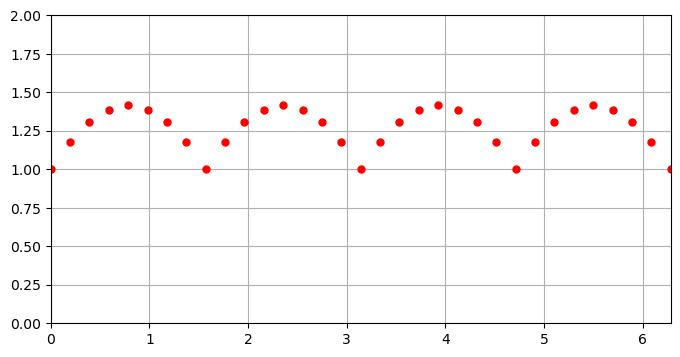

In [34]:
using PyPlot;
figure(figsize=(8,4));
plot(t_values, obj_values, "r.", markersize=10);
axis([0, 2*pi, 0, 2]);
grid("True");

What we are seeing in the linear program above is essentially the sum of the absolute value of $sin(t)$ and $cos(t)$ for all values of $t \in [0,2\pi]$. The reason for this is due to the defined constraints. We see the following two constraints explicitely declared in the problem formulation:

$$
    p - r = cos(t) \\
    q - s = sin(t)
$$

These can be rewritten as follows:

$$
    p = cos(t) + r \\
    q = sin(t) + s
$$

After rewriting as above, we then get the following objective:

$$
    \text{minimize} \; p + q + r + s = cos(t) + r + r + sin(t) + s + s
$$

The key part to remember in understanding why the behavior acts as it does, is:

$$
    p = cos(t) + r \geq 0 \\
    q = sin(t) + s \geq 0
$$

And since we want to minimize the sum of p, q, r, and s, any time $sin(t) \lt 0$ or $cos(t) \lt 0$, s and r will be precisely the absolute value of $sin(t)$ and $cos(t)$, respectively, such that $sin(t) + s = 0$ and $cos(t) + r = 0$. Any time either trignometric expression is greater than 0, the corresponding additive variable will equal 0 due to minimization. So in effect, the objective is always adding the absolute value of $sin(t)$ and $cos(t)$.

**b) Write out the dual LP. Interpret and solve the dual LP graphically. Does your solution agree with the solution found in part a)?**

To obtain the dual of the primal LP above, we notice a few things:
1. There are 2 primal constraints, and hence, 2 variables in the dual
2. There are 4 primal variables, and hence, 4 constraints in the dual
3. The primal minimization will become a dual maximization
4. We can treat the trigonometric functions as constants for each iteration

Therefore, we get the following formulation for the dual:

$$
    \max_{\lambda, \mu} \; cos(t) * \lambda + sin(t) * \mu \\
    \text{subject to:} \\
    \lambda \leq 1 \\
    -\lambda \leq 1 \\
    \mu \leq 1 \\
    -\mu \leq 1
$$

To solve this problem graphically, we will begin with a plot of the polyhedron created by the bounds on both dual variables. In the figures below, the red box depicts the feasible solution set, and the blue lines are to visually represent the axis of origin in 2D space.

Each of the figures depicts the solution for a different value of $t \in [\frac{\pi}{4}, \frac{3\pi}{4}, \frac{5\pi}{4}, \frac{7\pi}{4}]$

Due to difficulties coming up with a good way to plot contours on the plots below, I decided to depict counters by way of an evolving color scheme for various values of the objective function. When using values of t which are multiples of $\frac{\pi}{4}$, we notice that the maximum range of possible values the objective function can take based on the feasible set for $\lambda$ and $\mu$ is $-\frac{\sqrt{2}}{2} \leq \text{objective} \leq \frac{\sqrt{2}}{2}$. Since we are maximizing, we want to try finding the combination of $\lambda$ and $\mu$ that results in the $\frac{\sqrt{2}}{2}$ range. In the charts below, we let the progression from bad to good objective values go from red, magenta, yellow, green, to blue, where the red dot represents the combination of $\lambda$ and $\mu$ that results in the $-\frac{\sqrt{2}}{2}$ objective value and the blue dot represents the combination of $\lambda$ and $\mu$ that results in the $\frac{\sqrt{2}}{2}$ objective value. The blue dot is optimal for each value of t, and we will analyze the coordinates after to draw conclusions.

In [52]:
using PyPlot;

function plot_site(mode)
    plot([-1,-1], [-1,1], "k-");
    plot([-1,1], [-1,-1], "k-");
    plot([1,-1], [1,1], "k-");
    plot([1,1], [1,-1], "k-");
    plot([0,0],[-1.5,1.5], "b-");
    plot([-1.5,1.5],[0,0], "b-");
    axis("image");
    axis([-1.5,1.5,-1.5,1.5]); 
end

plot_site (generic function with 1 method)

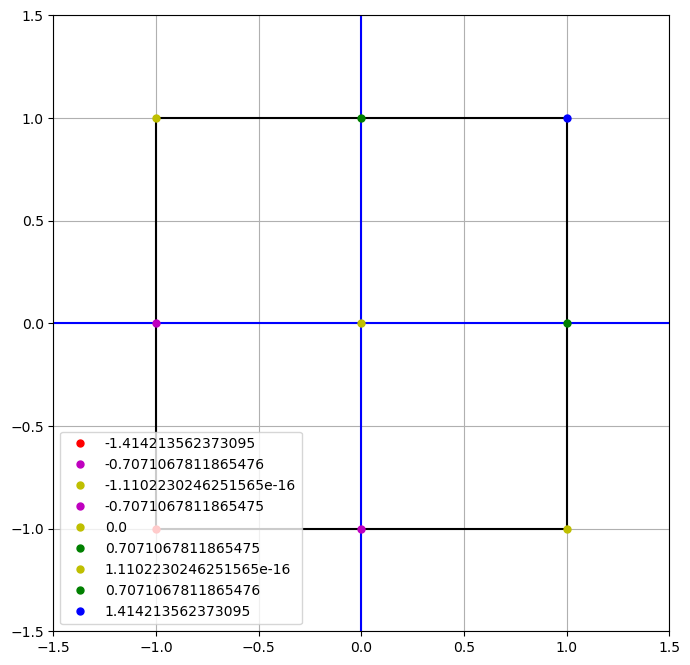

In [54]:
t = pi/4;
cosin_t = cos(t);
sin_t = sin(t);

x = [-1, 0, 1];

figure(figsize=(8,8));
plot_site(1)

for i in x
    for j in x
        curValue = cosin_t * i + sin_t * j
        
        if (curValue < -1)
            plot(i,j, "r.", markersize = "10", label = curValue)
        end
        
        if (-1 <= curValue < -0.1)
            plot(i,j, "m.", markersize = "10", label = curValue)
        end
        
        if (-0.1 <= curValue <= 0.1)
            plot(i,j, "y.", markersize = "10", label = curValue)
        end
        
        if (0.1 < curValue <= 1)
            plot(i,j, "g.", markersize = "10", label = curValue)
        end
        
        if (1 < curValue )
            plot(i,j, "b.", markersize = "10", label = curValue)
        end
        
    end 
end
legend(loc = "lower left")

grid("True");

Here we see that for $t = \frac{\pi}{4}$, the optimal combination of $\lambda$ and $\mu$, providing an objective value of 1.41421356 $(\sqrt{2})$, is $\lambda = 1, \mu = 1$. 

For $t = \frac{\pi}{4}$, the expression becomes 

$$
    \max_{\lambda,\mu} \;\; \frac{\sqrt{2}}{2}(\lambda + \mu)
$$

In this case, it obviously makes sense since both values of sin and cosin are positive, you want to max out the parameters to get the largest sum possible.

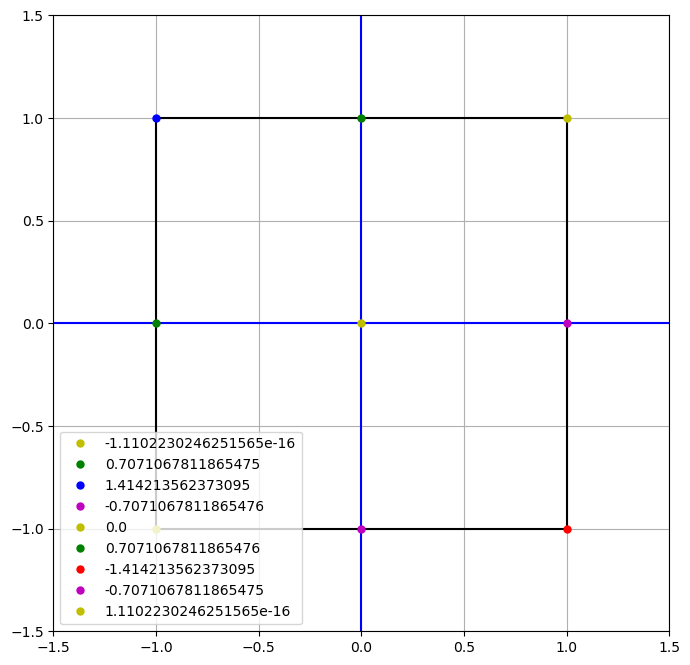

In [55]:
t = 3*pi/4;
cosin_t = cos(t);
sin_t = sin(t);

x = [-1, 0, 1];

figure(figsize=(8,8));
plot_site(1)

for i in x
    for j in x
        curValue = cosin_t * i + sin_t * j
        
        if (curValue < -1)
            plot(i,j, "r.", markersize = "10", label = curValue)
        end
        
        if (-1 <= curValue < -0.1)
            plot(i,j, "m.", markersize = "10", label = curValue)
        end
        
        if (-0.1 <= curValue <= 0.1)
            plot(i,j, "y.", markersize = "10", label = curValue)
        end
        
        if (0.1 < curValue <= 1)
            plot(i,j, "g.", markersize = "10", label = curValue)
        end
        
        if (1 < curValue )
            plot(i,j, "b.", markersize = "10", label = curValue)
        end
        
    end 
end
legend(loc = "lower left")

grid("True");

Here we see that for $t = \frac{3*\pi}{4}$, the optimal combination of $\lambda$ and $\mu$, providing an objective value of 1.41421356 $(\sqrt{2})$, is $\lambda = -1, \mu = 1$. 

For $t = \frac{3*\pi}{4}$, the expression becomes 

$$
    \max_{\lambda,\mu} \;\; \frac{\sqrt{2}}{2}(\mu - \lambda)
$$

In this case, we see that the optimal objective is found with a $\lambda = -1$ parameter. If we think about it, $cos(\frac{3*\pi}{4}) = -\frac{\sqrt{2}}{2}$, so $\lambda$ acts as the agent of absolute value so that the value magnitudes are maximized without regard to the sign.

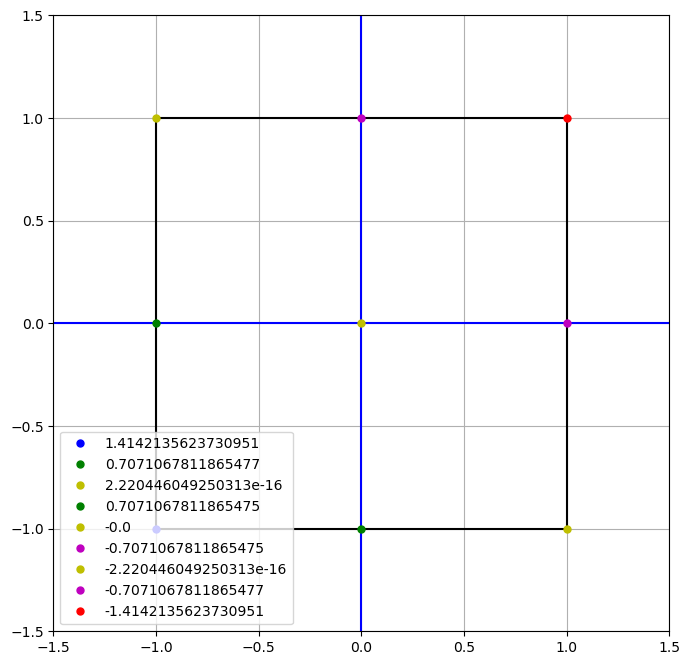

In [56]:
t = 5*pi/4;
cosin_t = cos(t);
sin_t = sin(t);

x = [-1, 0, 1];

figure(figsize=(8,8));
plot_site(1)

for i in x
    for j in x
        curValue = cosin_t * i + sin_t * j
        
        if (curValue < -1)
            plot(i,j, "r.", markersize = "10", label = curValue)
        end
        
        if (-1 <= curValue < -0.1)
            plot(i,j, "m.", markersize = "10", label = curValue)
        end
        
        if (-0.1 <= curValue <= 0.1)
            plot(i,j, "y.", markersize = "10", label = curValue)
        end
        
        if (0.1 < curValue <= 1)
            plot(i,j, "g.", markersize = "10", label = curValue)
        end
        
        if (1 < curValue )
            plot(i,j, "b.", markersize = "10", label = curValue)
        end
        
    end 
end
legend(loc = "lower left")

grid("True");

Here we see that for $t = \frac{5*\pi}{4}$, the optimal combination of $\lambda$ and $\mu$, providing an objective value of 1.41421356 $(\sqrt{2})$, is $\lambda = -1, \mu = -1$. 

For $t = \frac{5*\pi}{4}$, the expression becomes 

$$
    \max_{\lambda,\mu} \;\; \frac{-\sqrt{2}}{2}(\mu + \lambda)
$$

In this case, we see that the optimal objective is found with a $\lambda = -1$ parameter and a $\mu = -1$ parameter. If we think about it, $cos(\frac{5*\pi}{4}) = sin(\frac{5*\pi}{4}) = -\frac{\sqrt{2}}{2}$, so $\lambda$ and $\mu$ act as the agents of absolute value so that the value magnitudes are maximized without regard to the sign.

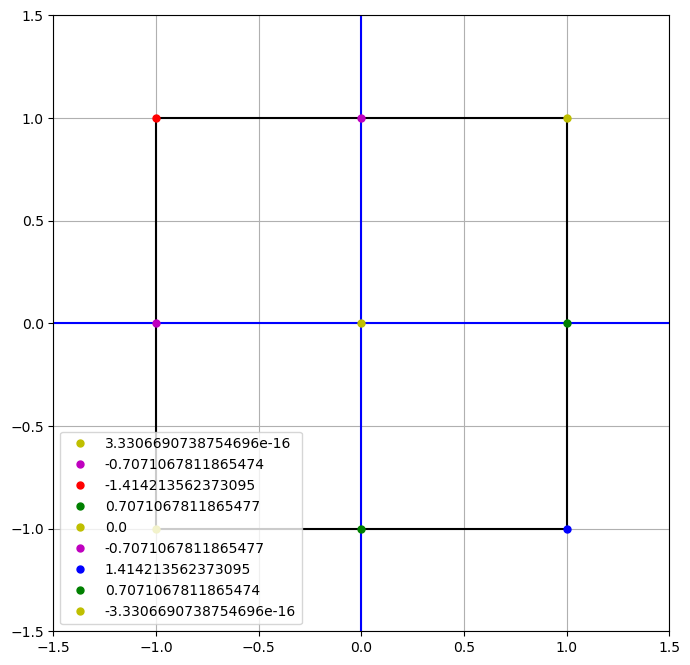

In [57]:
t = 7*pi/4;
cosin_t = cos(t);
sin_t = sin(t);

x = [-1, 0, 1];

figure(figsize=(8,8));
plot_site(1)

for i in x
    for j in x
        curValue = cosin_t * i + sin_t * j
        
        if (curValue < -1)
            plot(i,j, "r.", markersize = "10", label = curValue)
        end
        
        if (-1 <= curValue < -0.1)
            plot(i,j, "m.", markersize = "10", label = curValue)
        end
        
        if (-0.1 <= curValue <= 0.1)
            plot(i,j, "y.", markersize = "10", label = curValue)
        end
        
        if (0.1 < curValue <= 1)
            plot(i,j, "g.", markersize = "10", label = curValue)
        end
        
        if (1 < curValue )
            plot(i,j, "b.", markersize = "10", label = curValue)
        end
        
    end 
end
legend(loc = "lower left")

grid("True");

Here we see that for $t = \frac{7*\pi}{4}$, the optimal combination of $\lambda$ and $\mu$, providing an objective value of 1.41421356 $(\sqrt{2})$, is $\lambda = 1, \mu = -1$. 

For $t = \frac{7*\pi}{4}$, the expression becomes 

$$
    \max_{\lambda,\mu} \;\; \frac{\sqrt{2}}{2}(\lambda - \mu)
$$

In this case, we see that the optimal objective is found with a $\mu = -1$ parameter. If we think about it, $sin(\frac{7*\pi}{4}) = -\frac{\sqrt{2}}{2}$, so $\mu$ acts as the agent of absolute value so that the value magnitudes are maximized without regard to the sign.

In summary, and conclusion, since we want to maximize the linear combination of $sin(t)$ and $cos(t)$, we will always want the values to be positive. So, anytime the trigonometric functions have a negative value, the scaling factor will be $\lt 0$, and anytime the trigonometric functions are positive, the scaling factor will be $\gt 0$. Furthermore, since the overall objective is to maximize, we will always have the scaling factor be 1 or -1 depending on the sign of its trigonometric component. Again, the dual is essentially the sum of the absolute value of $sin(t)$ and the absolute value of $cos(t)$.